# Initialization

In [1]:
# !pip install sparqlwrapper openai tqdm pandas networkx numpy pandas label-studio guidance

import networkx as nx
import numpy as np
from collections import Counter
from SPARQLWrapper import SPARQLWrapper, JSON

# !label-studio start

In [2]:
import os
import json
import pandas as pd
import requests
import uuid
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from openai import OpenAI
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# set the maximum number of retries
MAX_RETRIES = 10

# Load environment variables
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

# Initialize OpenAI client
client = OpenAI(api_key=openai_api_key)

uuid = str(uuid.uuid4()).split("-")[-1]
uuid

'e878fe8942a5'

Prepare the open-ended Questions

In [90]:
# Define the function to call GPT
def call_gpt(gpt_prompt, examples=""):
    attempts = 0
    while attempts < MAX_RETRIES:
        try:
            response = client.chat.completions.create(
                model="gpt-4o",
                response_format={"type": "json_object"},
                messages=[
                    {
                        "role": "system",
                        "content": "You are a helpful assistant designed to output JSON.",
                    },
                    (
                        {
                            "role": "user",
                            "content": gpt_prompt + "\nExamples: " + examples,
                        }
                        if examples
                        else {"role": "user", "content": gpt_prompt}
                    ),
                ],
            )
            return response.choices[0].message.content
        except Exception as e:
            print(f"Error calling GPT: {e}")
            continue


# Define the prefix prompt
prefix = """
Generate 5 open-ended questions about different types: descriptive, explanatory, predictive, comparative and critical. Some templates are provided below:

descriptive Q: 
1. describe a [person]'s significant contributions during their career. Example: Please describe Albert Einstein’s contributions to the field of physics.
2. Provide a detailed description of the background and course of an [event]. Example: Please provide a detailed description of the background and course of the French Revolution.

explanatory Q:
1. Why did [person] take [action] at [time]? Example: Why did Nixon choose to resign from the presidency in 1974?
2. Explain the relationship between [entity A] and [entity B] and its significance. Example: Explain the relationship between Alexander the Great and Aristotle and its significance.

predictive Q:
1. Based on the historical behavior of [entity], what do you think it might do in the future? Example: Based on Tesla’s historical behavior, in which fields do you think it might innovate in the future?
2. Based on the current situation, how do you predict [event] will develop? Example: Based on the current international situation, how do you predict climate change policies will develop?

comparative Q:
1. Compare and contrast the similarities and differences between [entity A] and [entity B] in [aspect]. Example: Compare and contrast the leadership styles of Steve Jobs and Bill Gates.
2. Compare the impact of [historical event A] and [historical event B]. Example: Compare the impact of World War I and World War II on the global order

critical Q:
1. How do you evaluate the impact of [person/event] on [field]? Please explain your viewpoint. Example: How do you evaluate Martin Luther King’s impact on the civil rights movement? Please explain your viewpoint.
2. How do you think [theory/method] can be applied to [practical issue]? Please provide specific suggestions. Example: How do you think machine learning technology can be applied to medical diagnostics? Please provide specific suggestions.

Generate the questions, the type of the questions, the placeholders, the naturalness of your generated questions (choose from high, medium, and unnatural), the difficulty of the generated questions (choose from hard, medium and easy) and dbpedia_entities (link the placeholders to dbpedia entities) in JSON format.
"""

example = """
The following is an example of the output format:
{'question': 'Compare and contrast the similarities and differences between the Apple iPhone and Samsung Galaxy in terms of user interface design.',
 'type': 'comparative',
 'placeholders': {'entity A': 'Apple iPhone',
  'entity B': 'Samsung Galaxy',
  'aspect': 'user interface design'},
 'naturalness': 'high',
 'difficulty': 'medium',
 'dbpedia_entities': {'entity A': 'http://dbpedia.org/resource/IPhone',
  'entity B': 'http://dbpedia.org/resource/Samsung_Galaxy'}
}
"""

error_parse_samples = []


# Function to process a single API call
def process_call(i):
    raw_output = call_gpt(prefix, example)
    output = json.loads(raw_output)

    content = output.get("questions", "N/A")
    if content == "N/A":
        error_parse_samples.append(output)
        process_call(i)
    return content


# Initialize an empty list to store results
results = []
batch_size = 300
sample_size = batch_size * 5

# Use ThreadPoolExecutor for parallel processing
with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    futures = [executor.submit(process_call, i) for i in range(batch_size)]
    for future in tqdm(as_completed(futures), total=batch_size):
        result = future.result()
        if result:
            results.append(result)

# Convert results to a DataFrame
df = pd.DataFrame([item for sublist in results for item in sublist])
df.to_csv("questions_{uuid}_{sample_size}.csv")
df

Load the dataset from local

In [3]:
df = pd.read_csv("questions_v3.csv", index_col=0)
df["dbpedia_entities"] = df["dbpedia_entities"].apply(lambda x: eval(x))
df["placeholders"] = df["placeholders"].apply(lambda x: eval(x))
df

,question,type,placeholders,naturalness,difficulty,dbpedia_entities
0,Please describe Marie Curie's contributions to...,descriptive,{'person': 'Marie Curie'},high,medium,{'person': 'http://dbpedia.org/resource/Marie_...
1,Explain the relationship between the United Na...,explanatory,"{'entity A': 'United Nations', 'entity B': 'in...",high,medium,{'entity A': 'http://dbpedia.org/resource/Unit...
2,Based on current advancements in artificial in...,predictive,"{'entity': 'artificial intelligence', 'event':...",high,medium,{'entity': 'http://dbpedia.org/resource/Artifi...
3,Compare and contrast the educational philosoph...,comparative,"{'entity A': 'John Dewey', 'entity B': 'Paulo ...",high,medium,{'entity A': 'http://dbpedia.org/resource/John...
4,How do you evaluate the impact of the Industri...,critical,"{'event': 'Industrial Revolution', 'field': 'm...",high,hard,{'event': 'http://dbpedia.org/resource/Industr...
...,...,...,...,...,...,...
1499,Please describe Marie Curie’s contributions to...,descriptive,{'person': 'Marie Curie'},high,medium,{'person': 'http://dbpedia.org/resource/Marie_...
1500,Why did Mahatma Gandhi choose to launch the Sa...,explanatory,"{'person': 'Mahatma Gandhi', 'action': 'launch...",high,medium,{'person': 'http://dbpedia.org/resource/Mahatm...
1501,"Based on Apple's historical behavior, in which...",predictive,{'entity': 'Apple'},high,medium,{'entity': 'http://dbpedia.org/resource/Apple_...
1502,Compare and contrast the similarities and diff...,comparative,"{'entity A': 'traditional education systems', ...",high,medium,{'entity A': 'http://dbpedia.org/resource/Educ...


post process the dataframe, remove the rows with same placeholders and dbepedia entities

In [4]:
def post_process(df: pd.DataFrame):
    unique_sample = set()
    rows_to_keep = []

    for i, row in df.iterrows():
        type = row["type"]
        question = row["question"]
        placeholders = row["placeholders"]
        dbpedia_entities = row["dbpedia_entities"]
        try:
            # frozenset is hashable
            placeholders = frozenset(row["placeholders"].items())
            dbpedia_entities = frozenset(row["dbpedia_entities"].items())
            if (row["type"], placeholders, dbpedia_entities) not in unique_sample:
                unique_sample.add((row["type"], placeholders, dbpedia_entities))
                rows_to_keep.append(i)

        except Exception as e:
            print(f"Error processing row {i}: {e}")
            print("placeholders: ", placeholders)
            print((row["type"], placeholders, dbpedia_entities))
            print("question: ", question)
            pass

    # print(unique_sample)
    # print(f"Number of unique samples: {len(unique_sample)}")
    df_filtered = df.iloc[rows_to_keep].reset_index(drop=True)

    return df_filtered


df_post_processed = post_process(df)
df_post_processed

Error processing row 215: unhashable type: 'list'
placeholders:  {'person': 'Leonardo da Vinci', 'fields': ['art', 'anatomy']}
('descriptive', {'person': 'Leonardo da Vinci', 'fields': ['art', 'anatomy']}, {'person': 'http://dbpedia.org/resource/Leonardo_da_Vinci', 'field1': 'http://dbpedia.org/resource/Art', 'field2': 'http://dbpedia.org/resource/Anatomy'})
question:  Please describe Leonardo da Vinci's contributions to the fields of art and anatomy.
Error processing row 979: unhashable type: 'list'
placeholders:  frozenset({('field', 'art and science'), ('person/event', 'Leonardo da Vinci')})
('critical', frozenset({('field', 'art and science'), ('person/event', 'Leonardo da Vinci')}), {'person/event': 'http://dbpedia.org/resource/Leonardo_da_Vinci', 'field': ['http://dbpedia.org/resource/Art', 'http://dbpedia.org/resource/Science']})
question:  How do you evaluate Leonardo da Vinci’s impact on art and science? Please explain your viewpoint.
Error processing row 1080: unhashable type

,question,type,placeholders,naturalness,difficulty,dbpedia_entities
0,Please describe Marie Curie's contributions to...,descriptive,{'person': 'Marie Curie'},high,medium,{'person': 'http://dbpedia.org/resource/Marie_...
1,Explain the relationship between the United Na...,explanatory,"{'entity A': 'United Nations', 'entity B': 'in...",high,medium,{'entity A': 'http://dbpedia.org/resource/Unit...
2,Based on current advancements in artificial in...,predictive,"{'entity': 'artificial intelligence', 'event':...",high,medium,{'entity': 'http://dbpedia.org/resource/Artifi...
3,Compare and contrast the educational philosoph...,comparative,"{'entity A': 'John Dewey', 'entity B': 'Paulo ...",high,medium,{'entity A': 'http://dbpedia.org/resource/John...
4,How do you evaluate the impact of the Industri...,critical,"{'event': 'Industrial Revolution', 'field': 'm...",high,hard,{'event': 'http://dbpedia.org/resource/Industr...
...,...,...,...,...,...,...
825,How do you evaluate the impact of Rachel Carso...,critical,"{'person': 'Rachel Carson', 'event': 'her work...",high,medium,{'person': 'http://dbpedia.org/resource/Rachel...
826,Based on the current advancements in technolog...,predictive,"{'entity': 'artificial intelligence', 'time': ...",high,medium,{'entity': 'http://dbpedia.org/resource/Artifi...
827,Why did Mahatma Gandhi choose to launch the Sa...,explanatory,"{'person': 'Mahatma Gandhi', 'action': 'launch...",high,medium,{'person': 'http://dbpedia.org/resource/Mahatm...
828,Compare and contrast the similarities and diff...,comparative,"{'entity A': 'traditional education systems', ...",high,medium,{'entity A': 'http://dbpedia.org/resource/Educ...


Check whether the dbpedia url is correct

In [5]:
def check_url(url):
    try:
        response = requests.get(url, timeout=5)  # Added a timeout for faster failure
        return response.status_code == 200
    except:
        return False


def verify_and_filter_entities(df):
    valid_rows = set()

    # use ThreadPoolExecutor for parallel calling of check_url()
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        # futures = {
        #     executor.submit(check_url, url): (index, key)
        #     for index, row in df.iterrows()
        #     for key, url in row['dbpedia_entities'].items()
        # }
        # comes from `concurrent.futures` module, and is used to represent a result that will be available in the future.
        futures = {}
        for index, row in df.iterrows():
            for key, url in row['dbpedia_entities'].items():
                future = executor.submit(check_url, url)
                futures[future] = (index, key)

        url_results = {}  # store the results of the futures
        # process the futures as they are completed
        for future in tqdm(as_completed(futures), total=len(futures)):
            url_results[futures[future]] = future.result()

    # iterate through the DataFrame rows to filter out invalid ones
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        valid = True
        for key, url in row['dbpedia_entities'].items():
            # if any URL is invalid, set valid to False and break
            if not url_results[(index, key)]:
                valid = False
                break
        if valid:
            valid_rows.add(index)

    filtered_df = df.loc[list(valid_rows)].reset_index(drop=True)
    return filtered_df


filtered_df = verify_and_filter_entities(df_post_processed)
filtered_df.to_csv("filtered_questions_v3.csv")
filtered_df

100%|██████████| 830/830 [00:00<00:00, 18674.45it/s]


,question,type,placeholders,naturalness,difficulty,dbpedia_entities
0,Please describe Marie Curie's contributions to...,descriptive,{'person': 'Marie Curie'},high,medium,{'person': 'http://dbpedia.org/resource/Marie_...
1,Explain the relationship between the United Na...,explanatory,"{'entity A': 'United Nations', 'entity B': 'in...",high,medium,{'entity A': 'http://dbpedia.org/resource/Unit...
2,Based on current advancements in artificial in...,predictive,"{'entity': 'artificial intelligence', 'event':...",high,medium,{'entity': 'http://dbpedia.org/resource/Artifi...
3,Compare and contrast the educational philosoph...,comparative,"{'entity A': 'John Dewey', 'entity B': 'Paulo ...",high,medium,{'entity A': 'http://dbpedia.org/resource/John...
4,How do you evaluate the impact of the Industri...,critical,"{'event': 'Industrial Revolution', 'field': 'm...",high,hard,{'event': 'http://dbpedia.org/resource/Industr...
...,...,...,...,...,...,...
789,Compare and contrast the educational philosoph...,comparative,"{'entity A': 'John Dewey', 'entity B': 'Maria ...",high,hard,{'entity A': 'http://dbpedia.org/resource/John...
790,How do you evaluate the impact of Rachel Carso...,critical,"{'person': 'Rachel Carson', 'event': 'her work...",high,medium,{'person': 'http://dbpedia.org/resource/Rachel...
791,Based on the current advancements in technolog...,predictive,"{'entity': 'artificial intelligence', 'time': ...",high,medium,{'entity': 'http://dbpedia.org/resource/Artifi...
792,Compare and contrast the similarities and diff...,comparative,"{'entity A': 'traditional education systems', ...",high,medium,{'entity A': 'http://dbpedia.org/resource/Educ...


Calculate the statistics

In [6]:
# Count the number of questions for each type
type_counts = filtered_df["type"].value_counts()
type_counts

type
comparative    206
explanatory    196
critical       190
predictive     158
descriptive     44
Name: count, dtype: int64

In [7]:
# Count the number of questions for each naturalness
type_naturalness_counts = filtered_df.groupby(['type', 'naturalness']).size().unstack()
type_naturalness_counts

naturalness,high,medium
type,,
comparative,206.0,NaN
critical,189.0,1.0
descriptive,44.0,NaN
explanatory,196.0,NaN
predictive,150.0,8.0


In [8]:
type_difficulty_counts = filtered_df.groupby(['type', 'difficulty']).size().unstack()
type_difficulty_counts

difficulty,easy,hard,medium
type,,,
comparative,NaN,83.0,123.0
critical,NaN,73.0,117.0
descriptive,1.0,NaN,43.0
explanatory,1.0,34.0,161.0
predictive,NaN,46.0,112.0


/tmp/ipykernel_772660/3842824428.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=type_counts.index, y=type_counts.values, palette='viridis')


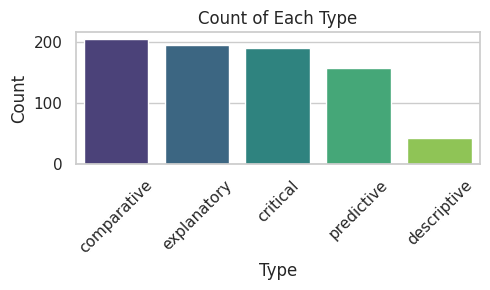

<Figure size 500x300 with 0 Axes>

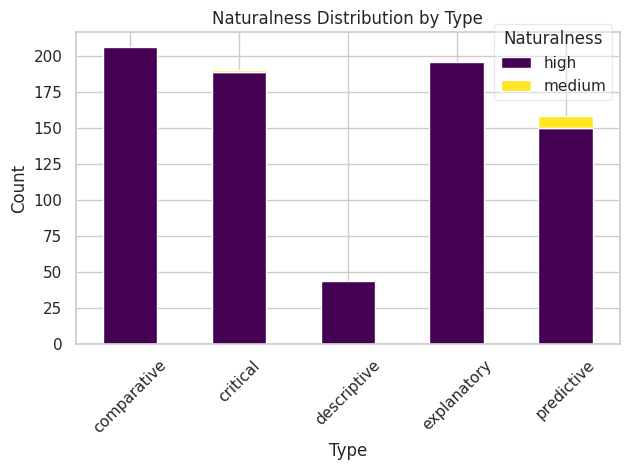

<Figure size 500x300 with 0 Axes>

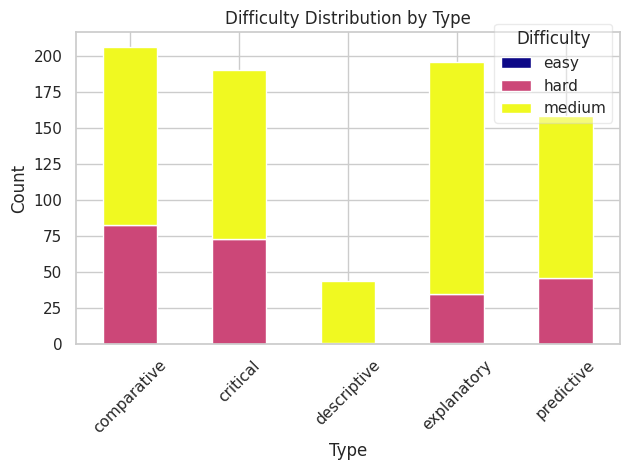

In [9]:
# set the style of the plots
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 10})

plt.figure(figsize=(5, 3))
sns.barplot(x=type_counts.index, y=type_counts.values, palette='viridis')
plt.title('Count of Each Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('figures/type_counts.png', dpi=300)
plt.show()

# plot the distribution of naturalness by type
plt.figure(figsize=(5, 3))
ax1 = type_naturalness_counts.plot(
    kind='bar', stacked=True, colormap='viridis', edgecolor='w'
)
plt.title('Naturalness Distribution by Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(
    title='Naturalness', loc='upper right', bbox_to_anchor=(1, 1.05), framealpha=0.4
)
plt.tight_layout()
plt.savefig('figures/naturalness_distribution.png', dpi=300)
plt.show()

# plot the distribution of difficulty by type
plt.figure(figsize=(5, 3))
ax2 = type_difficulty_counts.plot(
    kind='bar', stacked=True, colormap='plasma', edgecolor='w'
)
plt.title('Difficulty Distribution by Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(
    title='Difficulty', loc='upper right', bbox_to_anchor=(1, 1.05), framealpha=0.4
)
plt.tight_layout()
plt.savefig('figures/difficulty_distribution.png', dpi=300)
plt.show()

In [ ]:
def run_sparql_query(endpoint_url, query):
    sparql = SPARQLWrapper(endpoint_url)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return results


# DBpedia SPARQL endpoint
endpoint_url = "http://dbpedia.org/sparql"

# Your SPARQL query
query = """
SELECT DISTINCT ?node1 ?relation1 ?intermediateNode ?relation2 ?node2
WHERE {
  {
  # First hop
  <http://dbpedia.org/resource/Albert_Einstein> ?relation1 ?intermediateNode .

  # Second hop
  ?intermediateNode ?relation2 ?node2 .

  # Filter out relations
  FILTER(?relation1 NOT IN (<http://dbpedia.org/ontology/wikiPageWikiLink>, <http://www.w3.org/2002/07/owl#sameAs>, <http://dbpedia.org/property/wikiPageUsesTemplate>))
  FILTER(?relation2 NOT IN (<http://dbpedia.org/ontology/wikiPageWikiLink>, <http://www.w3.org/2002/07/owl#sameAs>, <http://dbpedia.org/property/wikiPageUsesTemplate>))

  }
  # Optionally, to also include direct 1-hop neighbors
  UNION
  {
    <http://dbpedia.org/resource/Albert_Einstein> ?relation1 ?node1 .
    BIND(?node1 AS ?intermediateNode)
    BIND(?relation1 AS ?relation2)
    BIND(?node1 AS ?node2)

    FILTER(?relation1 NOT IN (<http://dbpedia.org/ontology/wikiPageWikiLink>, <http://www.w3.org/2002/07/owl#sameAs>, <http://dbpedia.org/property/wikiPageUsesTemplate>))
  }

  # Filter out literal values if you only want URIs
  # FILTER(isIRI(?node2))
  UNION
  {
    <http://dbpedia.org/resource/Albert_Einstein> ?relation1 ?intermediateNode .
    VALUES ?relation1 {
      dbo:birthPlace
      dbo:deathPlace
      dbo:field
      dbo:knownFor
      dbo:award
      dbo:influenced
      dbo:influencedBy
    }
    OPTIONAL
    {
      ?intermediateNode ?relation2 ?node2
      FILTER(?relation2 NOT IN (<http://dbpedia.org/ontology/wikiPageWikiLink>, <http://www.w3.org/2002/07/owl#sameAs>, <http://dbpedia.org/property/wikiPageUsesTemplate>))
    }
  }
}
# LIMIT 1000
"""

# Run the query
results = run_sparql_query(endpoint_url, query)

# Process and print the results
for result in results["results"]["bindings"]:
    print(
        f"Node1: {result.get('node1', {}).get('value', '<http://dbpedia.org/resource/Albert_Einstein>')}"
    )
    print(f"Relation1: {result['relation1']['value']}")
    print(f"IntermediateNode: {result['intermediateNode']['value']}")
    print(f"Relation2: {result['relation2']['value']}")
    print(f"Node2: {result['node2']['value']}")
    print("---")

流式输出内容被截断，只能显示最后 5000 行内容。
Node1: <http://dbpedia.org/resource/Albert_Einstein>
Relation1: http://xmlns.com/foaf/0.1/depiction
IntermediateNode: http://commons.wikimedia.org/wiki/Special:FilePath/Einstein-formal_portrait-35.jpg
Relation2: http://xmlns.com/foaf/0.1/thumbnail
Node2: http://commons.wikimedia.org/wiki/Special:FilePath/Einstein-formal_portrait-35.jpg?width=300
---
Node1: <http://dbpedia.org/resource/Albert_Einstein>
Relation1: http://xmlns.com/foaf/0.1/depiction
IntermediateNode: http://commons.wikimedia.org/wiki/Special:FilePath/Einstein-with-habicht-and-solovine.jpg
Relation2: http://xmlns.com/foaf/0.1/thumbnail
Node2: http://commons.wikimedia.org/wiki/Special:FilePath/Einstein-with-habicht-and-solovine.jpg?width=300
---
Node1: <http://dbpedia.org/resource/Albert_Einstein>
Relation1: http://xmlns.com/foaf/0.1/depiction
IntermediateNode: http://commons.wikimedia.org/wiki/Special:FilePath/Einstein_1921_by_F_Schmutzer_-_restoration.jpg
Relation2: http://xmlns.com/foaf/0.1/th

In [ ]:
# save all the nodes/edges to NetworkX and then calculate the statistics of the graph

import networkx as nx
import numpy as np
from collections import Counter

G = (
    nx.DiGraph()
)  # hold directed edges. self loops are allowed but multiple(parell) edges are not.

for result in results["results"]["bindings"]:
    node1 = result.get('node1', {}).get(
        'value', 'http://dbpedia.org/resource/Albert_Einstein'
    )
    relation1 = result['relation1']['value']
    intermediateNode = result['intermediateNode']['value']
    relation2 = result['relation2']['value']
    node2 = result['node2']['value']

    G.add_edge(node1, intermediateNode, relation=relation1)
    G.add_edge(intermediateNode, node2, relation=relation2)

calculate_statistics(G)

Graph Statistics:
Number of nodes: 7141
Number of edges: 8285
Average in-degree: 1.16
Average out-degree: 1.16
Average total degree: 2.32

Top 5 most common relations:
http://www.w3.org/1999/02/22-rdf-syntax-ns#type: 1096
http://dbpedia.org/ontology/abstract: 1061
http://xmlns.com/foaf/0.1/depiction: 1015
http://www.w3.org/2000/01/rdf-schema#label: 915
http://www.w3.org/2000/01/rdf-schema#comment: 573

Number of connected components: 1
Size of the largest connected component: 7141

Is the graph a DAG? False
Is the graph strongly connected? False
Is the graph weakly connected? True
Diameter of the largest connected component: 4

Centrality Measures (for top 5 nodes):
Top 5 nodes by In-Degree Centrality:
http://www.w3.org/2004/02/skos/core#Concept: 0.0091
http://www.w3.org/2002/07/owl#Thing: 0.0064
http://dbpedia.org/ontology/Image: 0.0042
http://dbpedia.org/class/yago/YagoLegalActorGeo: 0.0035
http://dbpedia.org/class/yago/Abstraction100002137: 0.0031

Top 5 nodes by Out-Degree Centrali

In [ ]:
# verify the dataset from CWQ and WebQSP
from datasets import load_dataset

webqsp = load_dataset("rmanluo/RoG-webqsp", split="test")
cwq = load_dataset("rmanluo/RoG-cwq", split="test")

sample_webqsp = webqsp[0]
G_webqsp = nx.DiGraph()

graph = sample_webqsp["graph"]
for triple in graph:
    G_webqsp.add_edge(triple[0], triple[2], relation=triple[1])

print("Statistics for WebQSP...")
calculate_statistics(G_webqsp)

sample_cwq = cwq[0]
G_cwq = nx.DiGraph()

graph = sample_cwq["graph"]
for triple in graph:
    G_cwq.add_edge(triple[0], triple[2], relation=triple[1])

print("\nStatistics for CWQ...")
calculate_statistics(G_cwq)

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Statistics for WebQSP...
Graph Statistics:
Number of nodes: 1998
Number of edges: 5276
Average in-degree: 2.64
Average out-degree: 2.64
Average total degree: 5.28

Top 5 most common relations:
meteorology.tropical_cyclone.affected_areas: 398
meteorology.cyclone_affected_area.cyclones: 365
common.topic.notable_types: 167
location.location.containedby: 110
location.statistical_region.co2_emissions_per_capita: 100

Number of connected components: 1
Size of the largest connected component: 1998

Is the graph a DAG? False
Is the graph strongly connected? False
Is the graph weakly connected? True
Diameter of the largest connected component: 4

Centrality Measures (for top 5 nodes):
Top 5 nodes by In-Degree Centrality:
Jamaica: 0.2238
United States Dollar: 0.0566
The London 2012 Summer Olympics: 0.0361
Track and field athletics: 0.0341
Male: 0.0275

Top 5 nodes by Out-Degree Centrality:
Jamaica: 0.8438
Cuba: 0.0250
Cayman Islands: 0.0160
Bahamas: 0.0155
Puerto Rico: 0.0150

Top 5 nodes by Bet

In [ ]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.7 MB/s eta 0:00:00


In [ ]:
import tiktoken


def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


edge_list = [str(edge) for edge in edge_list]

num_tokens_from_string("\n".join(edge_list), "gpt-4o")

133782

In [ ]:
print(edge_list)

["('Jamaica', 'meteorology.cyclone_affected_area.cyclones', 'Tropical Storm Keith')", "('Jamaica', 'location.statistical_region.prevalence_of_undernourisment', 'g.12tb6gh4f')", "('Jamaica', 'location.statistical_region.electricity_consumption_per_capita', 'm.0nf4wmg')", "('Jamaica', 'location.statistical_region.market_cap_of_listed_companies_as_percent_of_gdp', 'g.1hhc3gxpy')", "('Jamaica', 'location.statistical_region.energy_use_per_capita', 'm.0nf5r2r')", "('Jamaica', 'sports.sport_country.athletic_performances', 'm.0b6562_')", "('Jamaica', 'location.statistical_region.gdp_nominal_per_capita', 'g.1hhc3xgmf')", "('Jamaica', 'location.statistical_region.consumer_price_index', 'g.1hhc4czcy')", "('Jamaica', 'location.statistical_region.cpi_inflation_rate', 'g.1hhc3cl0q')", "('Jamaica', 'location.statistical_region.debt_service_as_percent_of_trade_volume', 'g.11b71xnb4k')", "('Jamaica', 'location.country.administrative_divisions', 'Saint Andrew Parish')", "('Jamaica', 'meteorology.cyclone

In [ ]:
from SPARQLWrapper import SPARQLWrapper, JSON

sparql = SPARQLWrapper("http://dbpedia.org/sparql")
sparql.setQuery(
    """
    PREFIX dbo: <http://dbpedia.org/ontology/>
    PREFIX dbr: <http://dbpedia.org/resource/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

    SELECT ?event ?eventLabel ?date ?description
    WHERE {
      ?event dbo:wikiPageWikiLink dbr:Industrial_Revolution ;
             dbo:date ?date ;
             rdfs:label ?eventLabel ;
             dbo:abstract ?description .
      FILTER (lang(?eventLabel) = "en" && lang(?description) = "en")
    }
    ORDER BY ?date
"""
)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

for result in results["results"]["bindings"]:
    print(
        result["eventLabel"]["value"],
        result["date"]["value"],
        result["description"]["value"],
    )

Fédon's rebellion 1795-03-02 Fédon's rebellion (also known as the Brigands' War, or Fédon's Revolution, 2 March 1795 – 19 June 1796) was an uprising against British rule in Grenada. Although a significant number of slaves were involved, they fought on both sides (the majority being on the side of Fédon and his forces). Predominantly led by free mixed-race French-speakers, the stated purpose was to create a black republic as had already occurred in neighbouring Haiti rather than to free slaves, so it is not properly called a slave rebellion, although freedom of the slaves would have been a consequence of its success. Under the leadership of Julien Fédon, owner of a plantation in the mountainous interior of the island, and encouraged by French Revolutionary leaders on Guadeloupe, the rebels seized control of most of the island (St. George's, the capital, was never taken), but were eventually defeated by a military expedition led by General Ralph Abercromby. Planning for the rebellion beg